In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("./files/Aquifer_Petrignano.csv")

### Simplifications for the sake of the tutorial ###
# Drop data before 2009 for the purpose of this tutorial
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Drop one of the target columns, so we can focus on only one target
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

# Simplify column names
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']

targets = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in targets]
from datetime import datetime, date
df.index = pd.to_datetime(df.Date, format = '%d/%m/%Y', )
df = df.drop(['Date'], axis=1)
df.head()

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
Date,,,,,
2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


In [5]:
df['Drainage_Volume'] = df['Drainage_Volume'].interpolate()
df['River_Hydrometry'] = df['River_Hydrometry'].interpolate()
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()

In [6]:
# df_downsampled = df[['Date',
#                      'Depth_to_Groundwater',
#                      'Temperature',
#                      'Drainage_Volume',
#                      'River_Hydrometry'
#                      ]].resample('7D', on='Date').mean().reset_index(drop=False)
#
# df_downsampled['Rainfall'] = df[['Date',
#                                  'Rainfall'
#                                  ]].resample('7D', on='Date').sum().reset_index(drop=False)[['Rainfall']]
# uni = df_downsampled.drop(['Rainfall', 'Temperature', 'Drainage_Volume', 'River_Hydrometry'], axis=1)
uni = df['Depth_to_Groundwater']
temp = df['Temperature']
uni

Date
2009-01-01   -31.14
2009-01-02   -31.11
2009-01-03   -31.07
2009-01-04   -31.05
2009-01-05   -31.01
              ...  
2020-06-26   -25.07
2020-06-27   -25.11
2020-06-28   -25.19
2020-06-29   -25.18
2020-06-30   -25.25
Name: Depth_to_Groundwater, Length: 4199, dtype: float64

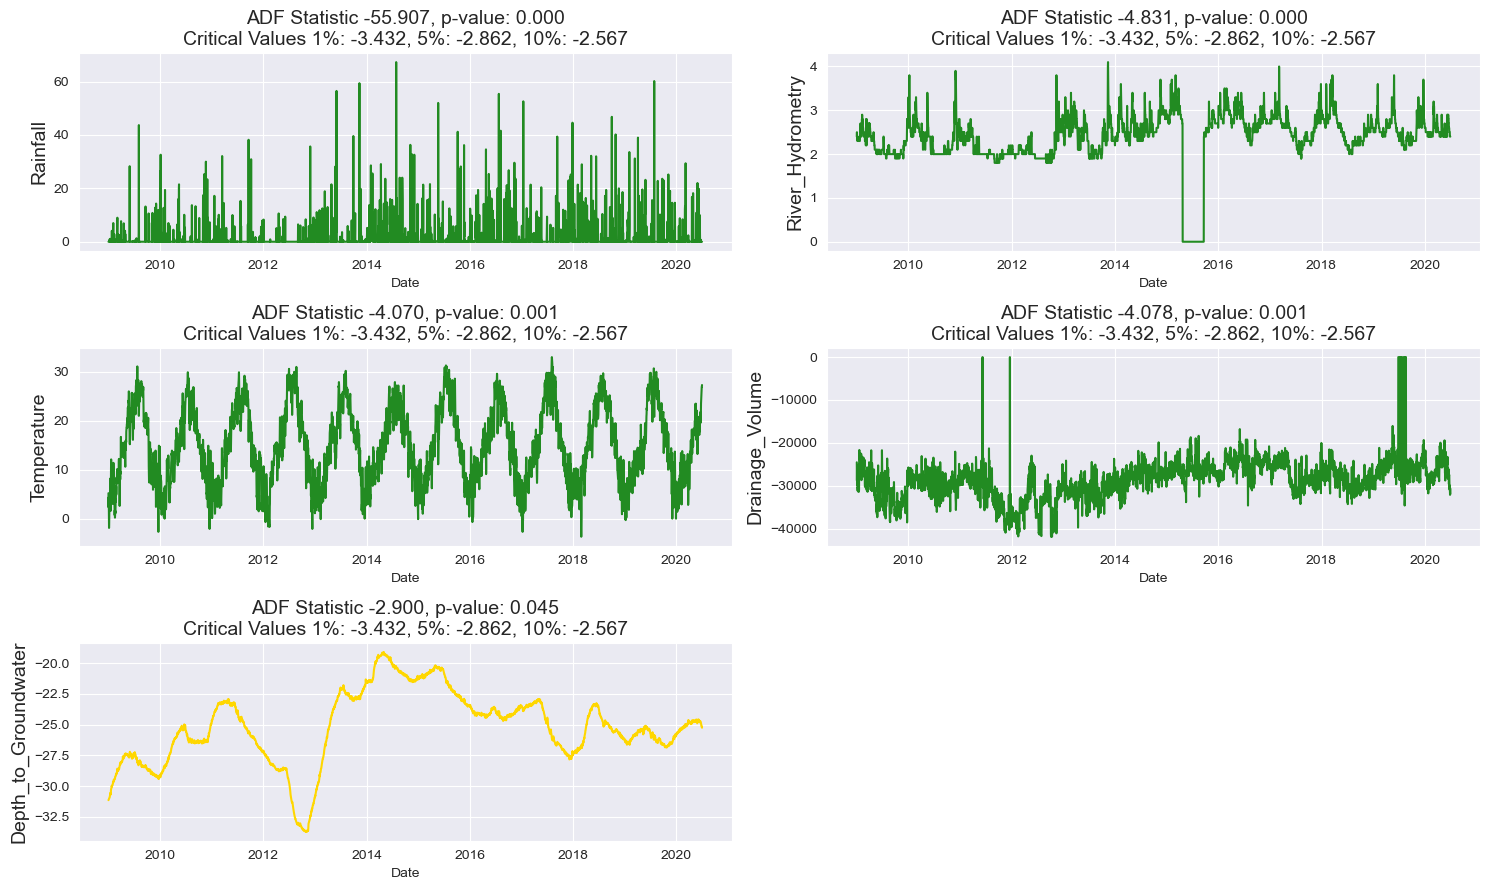

In [7]:
from statsmodels.tsa.stattools import adfuller
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'
    sns.lineplot(x=df.index, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df.Rainfall.values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df.Temperature.values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df.River_Hydrometry.values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df.Drainage_Volume.values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df.Depth_to_Groundwater.values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

In [8]:
def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)

adf_test(temp)

1. ADF :  -4.069936867799228
2. P-Value :  0.0010854767723929362
3. Num Of Lags :  29
4. Num Of Observations Used For ADF Regression: 4169
5. Critical Values :
	 1% :  -3.4319195204978277
	 5% :  -2.8622335279191637
	 10% :  -2.567139170972099


In [9]:
testSize = 100
print(temp.shape)
train= temp.iloc[:-testSize]
test= temp.iloc[-testSize:]
print(train.shape,test.shape)

(4199,)
(4099,) (100,)


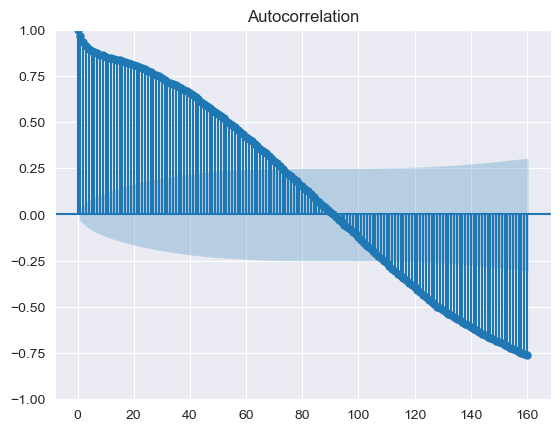

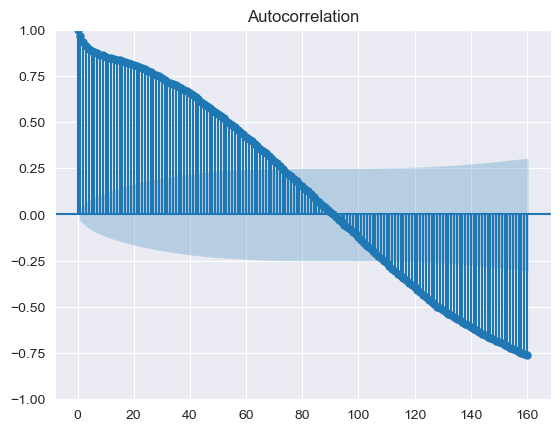

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(train, lags=160)


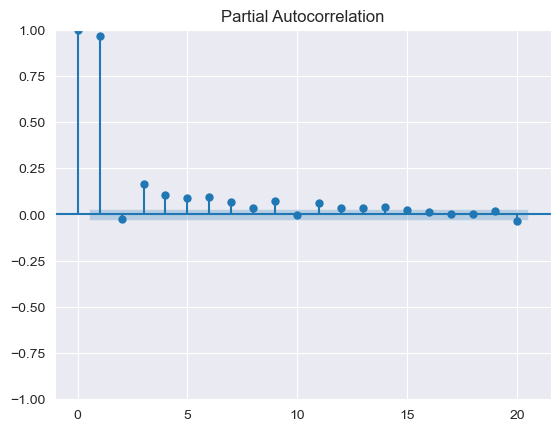

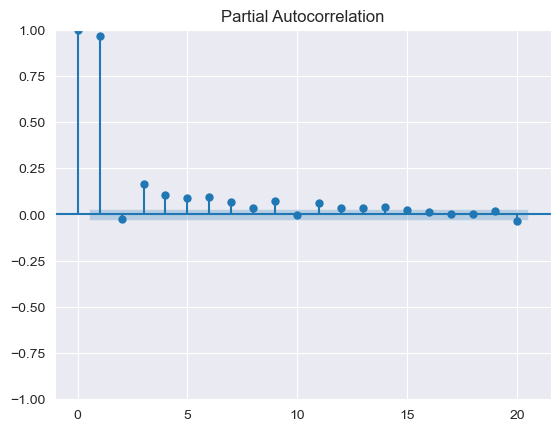

In [11]:
plot_pacf(train, lags=20)

In [12]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(train, trace=True, suppress_warnings=True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=17093.787, Time=5.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=28523.085, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=17371.253, Time=0.61 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=24096.765, Time=0.93 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=34817.424, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=17236.161, Time=1.78 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=17350.598, Time=3.02 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=17092.732, Time=6.13 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=17091.080, Time=3.91 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=17264.934, Time=0.74 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=17092.791, Time=4.54 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=17370.715, Time=0.62 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=17218.188, Time=1.75 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=17089.627, Time=7.08 sec
 ARIMA(5,0,2)(0,0,0

In [13]:
stepwise_fit.order

(4, 0, 2)

In [14]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train,order=stepwise_fit.order)
model=model.fit()
model.summary()

C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Temperature   No. Observations:                 4099
Model:                 ARIMA(4, 0, 2)   Log Likelihood               -8537.518
Date:                Wed, 05 Jul 2023   AIC                          17091.035
Time:                        16:32:38   BIC                          17141.583
Sample:                    01-01-2009   HQIC                         17108.931
                         - 03-22-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.9532      2.165      6.906      0.000      10.709      19.197
ar.L1          0.8030      0.041     19.791      0.000       0.723       0.883
ar.L2          0.7581      0.059     12.933      0.000       0.643       0.873
ar.L3         -0.7260      0.041    -17.885      0.000      -0.806      -0.646
ar.L4          0.1601      0.018      8.839      0.000       0.125       0.196
ma.L1          0.1382      0.039      3.534      0.000       0.062       0.215
ma.L2         -0.8035      0.031    -26.238      0.000      -0.863      -0.743
sigma2         3.7698      0.068     55.538      0.000       3.637       3.903
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               469.50
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Date'>

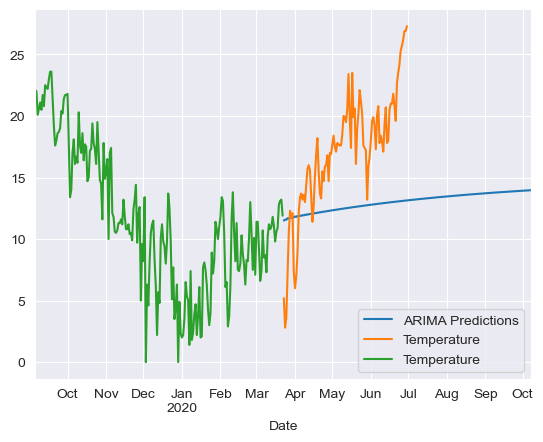

In [26]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end + 100,typ='levels').rename('ARIMA Predictions')
pred[-300:].plot(legend=True)
test.plot(legend=True)
train[-200:].plot(legend=True)

In [16]:
print(pred)

2009-01-01    14.953226
2009-01-02     5.524243
2009-01-03     2.659436
2009-01-04     5.217058
2009-01-05     1.143335
                ...    
2009-04-07    14.479019
2009-04-08    13.675113
2009-04-09    14.182952
2009-04-10    14.049421
2009-04-11    14.066481
Freq: D, Name: ARIMA Predictions, Length: 101, dtype: float64


In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test.mean()
rmse=sqrt(mean_squared_error(pred,test))
print(rmse)

ValueError: Found input variables with inconsistent numbers of samples: [101, 100]